## Range-Agnostic Multi-View Depth Estimation With Keyframe Selection

This notebooks provides a code example to use the pretrained models and reproduce the paper results.

## Imports and Config

Choose here the parameters for the following sections, like the device on which run inferences, the dataset etc.

In [10]:
# parameters
device = "cuda:0"             # cpu, cuda:<device id>
dataset = "blended"           # blended | tartanair | unrealstereo4k
unreal_benchmark = "video"    # video   | stereo
sample_idx = 10               # the sample to plot 

In [11]:
from lib.dataset import (
    BlendedMVSDataModule,
    TartanairDataModule,
    UnrealStereo4kDataModule,
)
from lib.metrics import compute_metrics, depth_to_disp
from lib.visualize import plot_sample
from lib.dataset.utils.preprocess import normalize_to_tensor, prepare_input
from torchvision import transforms as T
import pandas as pd
import matplotlib.pyplot as plt
from ramdepth import Model
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

In [12]:
# load data
DMClass = {
    "blended": BlendedMVSDataModule,
    "tartanair": TartanairDataModule,
    "unrealstereo4k": UnrealStereo4kDataModule,
}[dataset]

dm = DMClass(
    load_prevs=1
    if dataset == "unrealstereo4k" and unreal_benchmark == "stereo"
    else 4,
    batch_size=1,
    eval_transform=normalize_to_tensor,
    **{"stereo_as_prevs": unreal_benchmark == "stereo"}
    if dataset == "unrealstereo4k" else {},
)
dm.prepare_data()
dm.setup("test")
dl = dm.test_dataloader()

# load model
model = Model(
    pretrained={
        "blended": "blended",
        "unrealstereo4k": "blended",
        "tartanair": "tartanair",
    }[dataset],
    normalize_pose=dataset != "unrealstereo4k"
    and unreal_benchmark != "stereo",
    device=device,
)

## Quantitative Results

In this Section we provide sample code to reproduce the results showed in the main paper, in the cell below you can chose a pre-trained model between tartanair and blended, and the testing dataset

In [13]:
metrics = []
unit = "px" if dataset == "unrealstereo4k" and unreal_benchmark == "stereo" else "m"
for ex in tqdm(dl):
    inp = {k: v.to(device) for k, v in prepare_input(ex).items()}
    depth = model(
        **inp, n_cycles=40 if dataset == "unrealstereo4k" else 10,
    ).cpu()
    mask = ex["gt"] > 0
    if dataset == "unrealstereo4k" and unreal_benchmark == "stereo":
        disp = depth_to_disp(depth, ex["intrinsics"], ex["position"], ex["position_prev_0"])
        gt_disp = depth_to_disp(ex["gt"], ex["intrinsics"], ex["position"], ex["position_prev_0"])
        metrics.append(
            {k: v.item() for k, v in compute_metrics(disp, gt_disp, mask).items()}
        )
    else:
        metrics.append(
            {k: v.item() for k, v in compute_metrics(depth, ex["gt"], mask).items()}
        )
metrics = pd.DataFrame(metrics).mean(axis=0)

print(f"== metrics for {dataset} ({unit}) ==")
print(metrics)

  0%|          | 0/915 [00:00<?, ?it/s]

100%|██████████| 915/915 [03:00<00:00,  5.08it/s]

== metrics for blended (m) ==
mae                       0.298367
rmse                      1.173466
perc_l1_upper_thresh_1    0.064457
perc_l1_upper_thresh_2    0.028493
perc_l1_upper_thresh_3    0.015993
perc_l1_upper_thresh_4    0.010223
perc_l1_upper_thresh_8    0.003267
dtype: float64


## Qualitative Results

Here we show a simple snippet of code to plot predictions of our framework

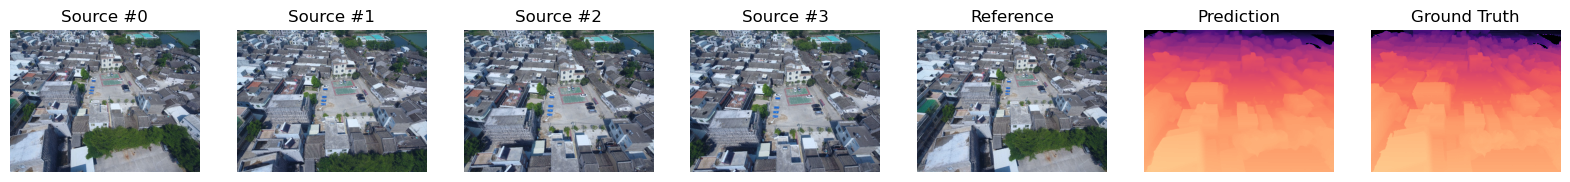

In [14]:
dl_iter = iter(dl)
for i in range(sample_idx):
    ex = next(dl_iter)

inp = {k: v.to(device) for k, v in prepare_input(ex).items()}
depth = model(
    **inp, n_cycles=40 if dataset == "unrealstereo4k" else 10,
).cpu()

plt.figure(figsize=(20, 5))
plot_sample(ex, depth)
plt.show()